TODO:
1. Test if having linear activation for output layer on the deceptor will cause it to "cheat"
2. Test different activation functions for output layer on the deceptor

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pprint
import time

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images, test_images = train_images / 256, test_images / 256

In [65]:
deceptor = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(28, input_shape=(28, 28), activation=tf.keras.activations.tanh)
])
#deceptor.compile()
deceptor.build((28, 28))
print(deceptor.layers[0].input_shape)

(28, 28)


In [66]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation="relu")
])
classifier.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
print(classifier.layers[0].input_shape)
print(classifier.summary())

(None, 28, 28)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               100480    
                                                                 
 dense_38 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
classifier_optimizer = tf.keras.optimizers.Adam(1e-6)
deceptor_optimizer = tf.keras.optimizers.Adam(1e-6)
classifier_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
# def deceptor_loss(classifierLoss):
#     return 1/classifierLoss


def deceptor_loss(original_loss, modified_loss):
    #return 1/(modified_loss - original_loss)
    return tf.math.exp(original_loss - modified_loss)

@tf.function
def train_step(images, labels, noise_weight=0.1):
#    print(labels)
    start_time=time.perf_counter()
    with tf.GradientTape() as cls_tape, tf.GradientTape() as dcp_tape:
        cls_tape.watch(classifier.variables)
        dcp_tape.watch(deceptor.variables)
        #Real Prediction
        real_prediction = classifier(tf.expand_dims(images, 0), training=True)
        
        #Fake Prediction
        noise_profile = tf.cast(deceptor(images, training=True), dtype=tf.float64)
        images = tf.math.add(tf.convert_to_tensor(images) * (1-noise_weight), noise_profile * noise_weight)
        images.set_shape((28, 28))
        fake_prediction = classifier(tf.expand_dims(images, 0), training=True)

        #Calculae Loss
        real_loss = classifier_loss(labels, real_prediction)
        fake_loss = classifier_loss(labels, fake_prediction)
        dcp_loss = deceptor_loss(fake_loss, real_loss)
        if real_loss < 0:
            print(real_loss)
        if real_loss < 0:
            print(real_loss)

    #Calculate Gradients
    gradients_of_classifier = cls_tape.gradient(fake_loss, classifier.trainable_variables)
    gradients_of_deceptor = dcp_tape.gradient(dcp_loss, deceptor.trainable_variables)
    
    #Apply Gradients
    classifier_optimizer.apply_gradients(zip(gradients_of_classifier, classifier.trainable_variables))
    deceptor_optimizer.apply_gradients(zip(gradients_of_deceptor, deceptor.trainable_variables))
    end_time = time.perf_counter()
    total_time = end_time-start_time
    print(f"Step time: {total_time} Classifier loss: {fake_loss} Deceptor loss: {dcp_loss}", end="\r")
    return [fake_loss, dcp_loss]
def train(images, labels, epochs, noise_weight=0.1):
    assert noise_weight <= 1.0
    losses = []
    for epoch in range(epochs):
        for i, (image_batch, label_batch) in enumerate(zip(images, labels)):
            print(f"Image: {i}", end="\r")
            step_loss = train_step(image_batch, label_batch)
            losses.append(step_loss)
        print(f"Finished epoch {epoch}")
    losses = np.asarray(losses)
    return np.transpose(losses)

In [68]:
history = train(train_images, train_labels, 1, noise_weight=0.1)

Tensor("sparse_categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("sparse_categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("sparse_categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)1/weighted_loss/value:0", shape=(), dtype=float32) Deceptor loss: Tensor("Exp:0", shape=(), dtype=float32)
Tensor("sparse_categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Finished epoch 034090002253652 Classifier loss: Tensor("sparse_categorical_crossentropy_1/weighted_loss/value:0", shape=(), dtype=float32) Deceptor loss: Tensor("Exp:0", shape=(), dtype=float32)


In [7]:
classifier(tf.expand_dims(train_images[0], 0), training=True)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.        , 0.        , 0.47352752, 0.        , 0.06124386,
        1.83079   , 0.        , 0.75525695, 2.6524215 , 4.3997517 ]],
      dtype=float32)>

In [ ]:
history2 = classifier.fit(train_images, train_labels, epochs=20, batch_size=60000)

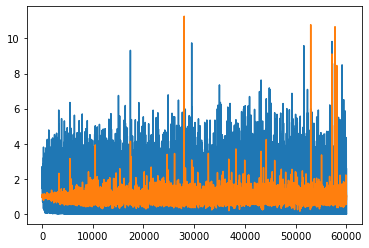

In [63]:
mpl.pyplot.plot(history[0])
mpl.pyplot.plot(history[1])

In [ ]:
mpl.pyplot.plot(history2.history['loss'])

In [ ]:
print(history2.history)

In [ ]:
train_step(train_images[0], train_labels[0], noise_weight=0.0)

In [ ]:
deceptor(train_images[0])

In [69]:
classifier.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 946us/step - loss: 1.6992


1.6992433071136475

In [16]:
print(classifier.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


Cringe:0.6588305830955505